# SVC with in-situ data
<br/>
We will use here the same method as in "svc_lab" notebook. The model will be train to predict the clusters defined in the "hplc_cluster" notebook. <br/> The dataset is  hplc_mfclusterised.

In [49]:
import pandas as pd 

data = pd.read_csv("/home/flavien/Documents/these/mf/Boussole/Output/Data/Compiled/hplc_mf_clusterised.csv")

print(
    f"The original data has "
    f"{len(data)} samples.")

The original data has 108 samples.


Select the descriptors (f440/f470 and f532/f47) and the target variable (the cluster).

In [50]:
descriptors = data[["f440_f470", "f532_f470"]]
target = data["cluster"]

Let's check the distribution of the samples in the f440_f470; f532_f470 space.

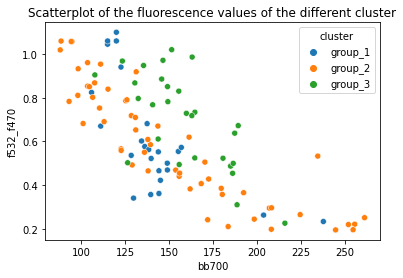

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data = data, x = "bb700", y = "f532_f470", hue = "cluster")
plt.title("Scatterplot of the fluorescence values of the different cluster")
plt.show()

We notice here that the different clusters are all evenly distributed in the scatter. It won't be possible to differenciate them with a SVC model as we did in the lab for the taxa.<br/>
We suspect an effect here of the Chla concentration, we can do the same plot with the Chla concentration as colour scale.

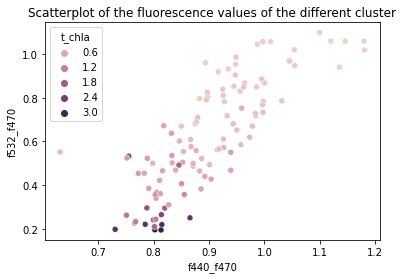

In [63]:
sns.scatterplot(data = data, x = "f440_f470", y = "f532_f470", hue = "t_chla")
plt.title("Scatterplot of the fluorescence values of the different cluster")
plt.show()

Indeed, we notice a clear gradient of Chla on this scatterplot, leading to fade the effect of the different accessories pigment compositions. <br/>
We need to correct this bias.

In [53]:
#use the bbp to erase the chla effect
data = data.assign(f440_bbp = lambda x: x['fluo_440']/x['cdom'],
                f470_bbp= lambda x: x['fluo_470']/x['cdom'],
                f532_bbp = lambda x: x['fluo_532']/x['cdom'],
                f440b_f470b = lambda x: x['f440_bbp']/x['f470_bbp'],
                f532b_f470b = lambda x: x['f532_bbp']/x['f470_bbp'],
                f532_f440 = lambda x: x['fluo_532']/x['fluo_440'])

In [54]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate

histogram_gradient_boosting = HistGradientBoostingClassifier()


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

new_descriptors = data[["f440_f470", "f532_f470", "bb700", "cdom", "temp"]]


parameters_hgb = [{'max_iter': [1000],
                'learning_rate': [0.1],
                'max_depth' : [25],
                'l2_regularization': [0.5],
                'scoring': ['f1_micro']}]

cv = StratifiedKFold(n_splits=10)

grid_search_hgb = GridSearchCV(estimator = histogram_gradient_boosting,
                           param_grid = parameters_hgb,
                           scoring = 'accuracy',
                           cv = cv,
                           n_jobs = 2)
grid_search_hgb.fit(new_descriptors, target)
best_accuracy_hgb = grid_search_hgb.best_score_
best_paramaeter_hgb = grid_search_hgb.best_params_
print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100))
print("Best Parameter of HGB:", best_paramaeter_hgb) 

Best Accuracy of HGB: 79.55 %
Best Parameter of HGB: {'l2_regularization': 0.5, 'learning_rate': 0.1, 'max_depth': 25, 'max_iter': 1000, 'scoring': 'f1_micro'}


In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_descriptors, target, test_size =0.3, stratify = target)

In [57]:
#histogram boosting gradient classifer

grid_search_hgb.fit(X_train,y_train)
y_pred_hgb = grid_search_hgb.predict(X_test)

[[ 6  1  1]
 [ 1 16  0]
 [ 3  1  4]]


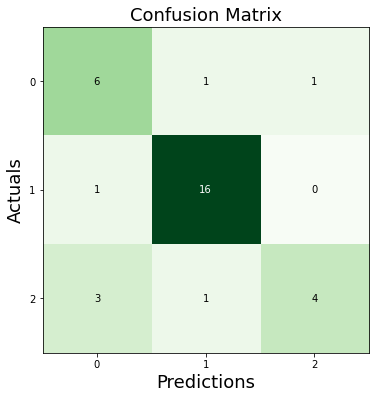

In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
cm_hgb = confusion_matrix(y_test, y_pred_hgb)
print(cm_hgb)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm_hgb, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [61]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",precision_score(y_test, y_pred_hgb, average = None))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",recall_score(y_test, y_pred_hgb, average = None))

Precision: [0.6        0.88888889 0.8       ]
Recall: [0.75       0.94117647 0.5       ]


# Regression model to predict pigment concentration

We will firstly try to predict the Zea and Fuco concentration as they both have clear pattern in the dataset. (c.f. clustering notebook). <br/>
We will try to predict the concentration of zeaxanthin in a first place. Then we will try to predict its relative contribution to the total pigment concentration.

In [12]:
#We will use the same descriptor as for classification model, and the target will be Zea in a first place
y_zea = data['zea']
y_fuco = data['fuco']
y_hf = data['hex']
y_tchlb = data['t_chlb']

pigments = ["zea", "hex", "but", "fuco", "allo", "t_chlb"] # a list of pigments

descriptors = data[['f440_f470', 'f532_f470', 'cdom', 'bb700']] #the same descriptors as for classification
f3x1m = data[['fluo_440', 'fluo_532', 'fluo_470']] #the stand alone version of the 3x1m fluorometer
classic_fluo = data[['fluo_470']] #the typical wevlength used with BGC-Argo
temp_desc = data[['temp']] #The temperature is our dummy predictor 

The selected model will be a reguralized linear model. This is a linear model that reduce overfitting in order to optimize the generalization of the model. This is called ridge, in sklearn.

In [13]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

alphas = np.logspace(-2, 0, num=20)

regression_model = make_pipeline(StandardScaler(),
                                RidgeCV(alphas = alphas, store_cv_values = True))


In [14]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits= 10, test_size = 0.2)

cv_results = cross_validate(regression_model, descriptors, y_tchlb,
                            cv=cv, scoring="neg_mean_absolute_percentage_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)

In [15]:
train_error = -cv_results["test_score"]
print(f"Mean absolute percentage error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean absolute percentage error of linear regression model on the train set:
2.646 +/- 0.885


After a test on several pigment concentration we notice that some model perform well when other are completely out of scope. We will compute the accuracy score (here, the MAP) on the different pigments and visualise it. We will test all pigments that are plotted on the figure 1 of the clustering RMDnotebook.

In [16]:
scores_list = []
sd_list = []

scores_flbb_list = []
sd_flbb_list = []
pig_list = []

pos = 0
for pig in ("allo", "but", "chl_c1_c2",
            "chl_c3", "chlb", "diad",
            "diat", "dv_chla", "dv_chlb",
            "fuco", "hex", "lutein",
            "neox", "peri", "prasi",
            "viola", "zea"):
    temp_target = data[pig]
    temp_cv_results = cross_validate(regression_model, f3x1m, temp_target,
                            cv=cv, scoring="neg_mean_absolute_percentage_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)
    temp_cv_flbb_results = cross_validate(regression_model, classic_fluo, temp_target,
                            cv=cv, scoring="neg_mean_absolute_percentage_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)

    temp_score = -temp_cv_results["test_score"]
    temp_flbb_score = -temp_cv_flbb_results["test_score"]

    scores_list.append(temp_score.mean())
    sd_list.append(temp_score.std())
    scores_flbb_list.append(temp_flbb_score.mean())
    sd_flbb_list.append(temp_flbb_score.std())
    pig_list.append(pig)

In [23]:
#compute the dataframe of pig and scores
scores = pd.DataFrame(list(zip(pig_list, scores_list, scores_flbb_list, sd_list, sd_flbb_list)),
 columns = ['pigment', 'scores', 'flbb_scores', 'sd', 'flbb_sd'])

#isolate and remove pigments that have a mape over 100
bad_pred = scores[scores['flbb_scores'] > 100]

good_pred = scores[scores['scores'] < 100]

We visulaize the MAPE of the pigment that can be well predicted by the model. We compare the performance of the prediction made from 3 wavelength and from the only 470nm wavelength.

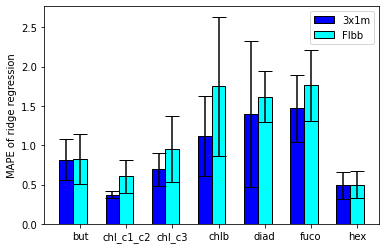

In [21]:
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = good_pred['scores']
 
# Choose the height of the cyan bars
bars2 = good_pred['flbb_scores']
 
# Choose the height of the error bars (bars1)
yer1 = good_pred['sd']
 
# Choose the height of the error bars (bars2)
yer2 = good_pred['flbb_sd']
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='3x1m')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='Flbb')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], good_pred['pigment'])
plt.ylabel('MAPE of ridge regression')
plt.legend()
 
# Show graphic
plt.show()

We see on the graph that the 3x1m fluorometer do not perform much better than the classic flbb fluorometer on the regression prediction of the different pigment concentration.

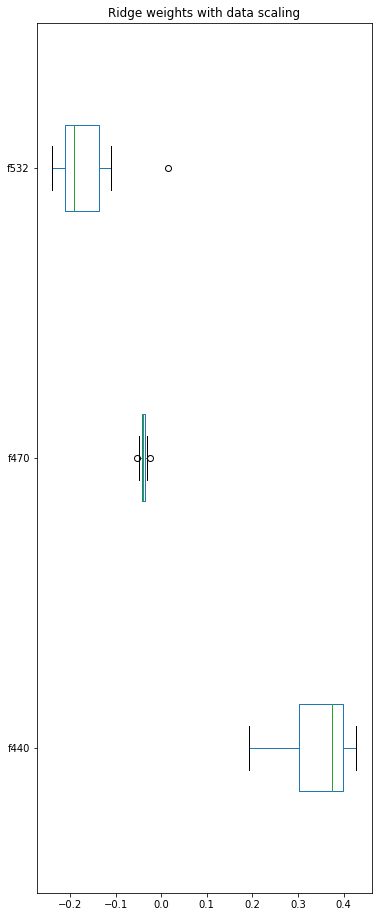

In [29]:
cv_results = cross_validate(regression_model, f3x1m, y_fuco,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=['f440', 'f470', 'f532'])

weights_ridge.plot.box(vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights with data scaling")

This plot show the weight applied to the different excitation wavelength.

We will try to predict the relative contribution of each pigment.

In [42]:
#use the bbp to erase the chla effect
data = data.assign(allo_relative = lambda x: x['allo']/x['sumpig'],
                but_relative = lambda x: x['but']/x['sumpig'],
                chl_c1_c2_relative = lambda x: x['chl_c1_c2']/x['sumpig'],
                chl_c3_relative = lambda x: x['chl_c3']/x['sumpig'],
                chlb_relative = lambda x: x['chlb']/x['sumpig'],
                diad_relative = lambda x: x['diad']/x['sumpig'],
                diat_relative = lambda x: x['diat']/x['sumpig'],
                dv_chla_relative = lambda x: x['dv_chla']/x['sumpig'],
                dv_chlb_relative = lambda x: x['dv_chlb']/x['sumpig'],
                fuco_relative = lambda x: x['fuco']/x['sumpig'],
                hex_relative = lambda x: x['hex']/x['sumpig'],
                lutein_relative = lambda x: x['lutein']/x['sumpig'],
                neox_relative = lambda x: x['neox']/x['sumpig'],
                peri_relative = lambda x: x['peri']/x['sumpig'],
                prasi_relative = lambda x: x['prasi']/x['sumpig'],
                viola_relative = lambda x: x['viola']/x['sumpig'],
                zea_relative = lambda x: x['zea']/x['sumpig'])

pigments = ["allo", "but", "chl_c1_c2",
            "chl_c3", "chlb", "diad",
            "diat", "dv_chla", "dv_chlb",
            "fuco", "hex", "lutein",
            "neox", "peri", "prasi",
            "viola", "zea"]
            
pig_relative = [i + '_relative' for i in pigments]

In [44]:
scores_list = []
sd_list = []

scores_flbb_list = []
sd_flbb_list = []
pig_list = []

pos = 0
for pig in pig_relative:
    temp_target = data[pig]
    temp_cv_results = cross_validate(regression_model, f3x1m, temp_target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)
    temp_cv_flbb_results = cross_validate(regression_model, classic_fluo, temp_target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)

    temp_score = -temp_cv_results["test_score"]
    temp_flbb_score = -temp_cv_flbb_results["test_score"]

    scores_list.append(temp_score.mean())
    sd_list.append(temp_score.std())
    scores_flbb_list.append(temp_flbb_score.mean())
    sd_flbb_list.append(temp_flbb_score.std())
    pig_list.append(pig)

In [45]:
#compute the dataframe of pig and scores
scores = pd.DataFrame(list(zip(pig_list, scores_list, scores_flbb_list, sd_list, sd_flbb_list)),
 columns = ['pigment', 'scores', 'flbb_scores', 'sd', 'flbb_sd'])

#isolate and remove pigments that have a mape over 100
bad_pred = scores[scores['flbb_scores'] > 100]

good_pred = scores[scores['scores'] < 100]

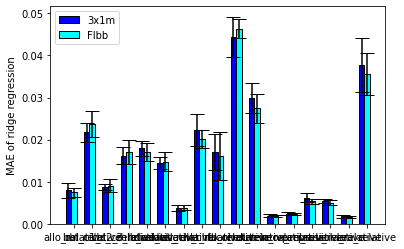

In [46]:
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = good_pred['scores']
 
# Choose the height of the cyan bars
bars2 = good_pred['flbb_scores']
 
# Choose the height of the error bars (bars1)
yer1 = good_pred['sd']
 
# Choose the height of the error bars (bars2)
yer2 = good_pred['flbb_sd']
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='3x1m')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='Flbb')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], good_pred['pigment'])
plt.ylabel('MAE of ridge regression')
plt.legend()
 
# Show graphic
plt.show()

Does not perform better either....